# Observing "impossible" double descent in simple linear regression

Double descent is the empirical observation that prediction test error can "descend" as more and more columns / features are added to the data.  Traditional bias-variance theory indicated it should be impossible because there was a U-curved "sweet spot" of optimal test error with only a few columns (features) because sampling variance increased with ss more columns are added.  Before this sweet spot, the model **underfits** the data; training error and test error are both high.  Beyond this sweet spot, the model **overfits** the data, meaning it is fitting noise rather than signal; as a result training error is low but test error is high.

At first, double descent was assumed to be due to some special features of deep learning or neural nets.  But in the 2020's, doube descent was observed in linear regression, too.  It was a shock.  Various researchers have started developing the theory on how, when, and where linear regression can exhibit double descent, including the Dar et al. (2023) paper cited below, which greatly inspired me.

But the math is complicated.  Code is simpler.  So this notebook illustrates the bias-variance trade-off and double descent in a linear regression model using simple python libraries.  These also help us test our intuitions by running different variations.  I also address an objection by Curth et al. (2023).

# Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Data set

Here I load a data set to analyze.  In an earlier [R version of this notebook](https://github.com/jeanimal/farewell_bias_variance), I used the "mtcars" data set which has data on various models in Motor Trend cars of the year.

The goal is to predict the miles per gallon (mpg) of various models based on their other characteristics.

In [2]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


# Split X and y

Here we put the data in a standard format for sklearn's model estimtion and error metrics.  If you use your own data set, you will need to tweak the target column and remove the non-numeric columns-- or code them into numbers, e.g. with one-hot encoding.

In [5]:
TARGET_COL = "mpg"

In [6]:
NON_NUMERIC_COLS = ["model"]

In [7]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

# Making the study of overparameterization easier

In this section, I summarize functions to sample our data by the number of rows and columns.

Why?

To study bias-variance and double descent, we need to view our model estimation in terms of the overparameterization ratio, defined as:

      `overparametrization ratio = num_parameters / num_rows`

 The overparametrization ratio distinguish these classes of behavior:
    * less than 1: uncerparameterized (where we will see bias-variance U curves)
    * equal to 1: interpolating
    * greater than 1: overparameterized (where we might see the right half of double descent).

In many estimation models, the number of parameters is closely related to the number of columns. For example, in ordinary least squares (OLS) regression without an intercept, the number of parameters equals the number of columns, and when there is an intercept, the number of parameters is number of columns + 1.

However, sklearn's train_test_split function takes a proportion of taining rows as input and always uses all columns of the data set.  So I wrote wrappers to directly control the number of training rows and columns.

The overparameterization ratio is described in this paper:
    Hastie, T., Montanari, A., Rosset, S., & Tibshirani, R. J. (2020). Surprises in High-Dimensional
    Ridgeless Least Squares Interpolation. http://arxiv.org/abs/1903.08560


Below I do manual sampling of rows and columns to give an idea of the goal.

In [8]:
rng = np.random.RandomState(10) # For reproducibility
num_sampled_rows = 4
num_sampled_columns = 5

In [9]:
row_indices = rng.choice(df.index, num_sampled_rows, replace=False)

In [10]:
X_subset = X.iloc[row_indices]
y_subset = y.iloc[row_indices]

In [11]:
X_subset = X_subset.sample(n=num_sampled_columns, random_state=rng, axis=1)

In [12]:
X_subset

,hp,cyl,carb,qsec,wt
20,97,4,1,20.01,2.465
7,62,4,2,20.00,3.190
5,105,6,1,20.22,3.460
2,93,4,1,18.61,2.320


In [13]:
y_subset

20    21.5
7     24.4
5     18.1
2     22.8
Name: mpg, dtype: float64

## Using the package just to sample rows and columns

I have a python package to help sample a dataframe in a way that makes it easy to control the rows and columns, which helps us control the overparameterization ratio, defined as the number of parameters / number of rows.

In [14]:
from double_descent_dar import sample_eval

In [15]:
random_state = np.random.RandomState(15) # For reproducibility
num_sampled_rows = 3
num_sampled_columns = 4

In [16]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_sampled_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)

using train_size 0.09375


In [17]:
X_train

,hp,vs,disp,drat
17,66,1,78.7,4.08
29,175,0,145.0,3.62
15,215,0,460.0,3.00


In [18]:
y_train

17    32.4
29    19.7
15    10.4
Name: mpg, dtype: float64

What we will do is fit a linear regression on this data and then measure out of sample error.


In [19]:
model = linear_model.LinearRegression(fit_intercept=True)

In [20]:
model.fit(X_train, y_train)

LinearRegression()

In [21]:
my_metric = root_mean_squared_error
# my_metric = mean_absolute_error

In [22]:
train_error = my_metric(y_train, model.predict(X_train))
train_error

np.float64(1.2685725232129475e-14)

In [23]:
test_error = my_metric(y_test, model.predict(X_test))
test_error

np.float64(5.635025655963682)

As expected, train error (in-sample fit) is lower than test error (out of sample).

We will do this again and again and look at the mean metric value for combinations of number of rows and columns.

# Bias-variance U curve

Seeing a traditional bias-variance U curve requires that the number of parameters should be a lot less than the number of rows.  Since the data set has 9 columns, we will need a lot more rows. This section will sample 15 rows (out of a total of 32) to train on.

We will sample between 2 and 8 columns (out of a total of 10 numeric columns) to see how the error metric varies by the number of parameters.

Note that the regression used here includes an intercept, so 8 columns + 1 intercept -> 9 parameters.  With 15 rows to train on, full interpolation would be reached with 15 columns.

In [24]:
X.shape

(32, 10)

In [25]:
num_train_rows = 15

In [26]:
model = linear_model.LinearRegression(fit_intercept=True)

We will look at the train and test error with the root mean squared metric, the metric minimized by Ordinary Least Squares (OLS)-- although OLS minimizes only training (in-sample) error. 

In [27]:
metric = root_mean_squared_error
metrics = [
        sample_eval.MetricTuple('train', metric_func=metric, dataset_type=sample_eval.DatasetType.train),
        sample_eval.MetricTuple('test', metric_func=metric, dataset_type=sample_eval.DatasetType.test)
    ]

In [28]:
num_samples = 300
random_state = np.random.RandomState(11)  # set for reproducibility
num_columns_list = range(1, X.shape[1])
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(
    X, y, num_train_rows, num_columns_list=num_columns_list, model=model,
    metric_tuples=metrics, num_samples=num_samples,
    replace=False, random_state=random_state)

Below we see the mean training error decreases for more columns sampled.  Starting at 6 columns sampled, mean root mean square error drops below 2.0.

In contrast, mean test error goes down but then goes back up.   Mean test error reaches its minimum at 3 columns sampled, at a value of ~3.45. 

In [29]:
print(pd.DataFrame({
    'cols':num_columns_list,
    'train': np.mean(metric_dict['train'], axis=0),
    'test': np.mean(metric_dict['test'], axis=0)}).to_string(index=False))

 cols    train     test
    1 3.876230 4.545854
    2 3.066004 3.924209
    3 2.591921 3.454348
    4 2.293291 3.515853
    5 2.094819 3.647092
    6 1.953831 3.845990
    7 1.776364 4.208101
    8 1.613586 4.822576
    9 1.491465 5.442986


Let's plot test error to see the classic U shape.

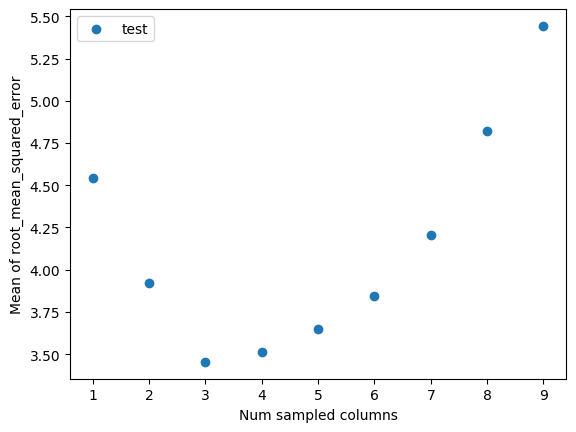

In [30]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

The test error (in orange) display a beautiful U shape.  The linear regression's lowest average test (out-of-sample) error was achieved at 4 columns, which with the intercept means 5 parameters to fit.  This is much less than the 9 columns available in the data set.

(There is no simple theory that predicts what the optimal number of parameters will be.) 


Now let's look at a plot that includes the training error.  Notice that the training error continues to decrease as more columns are added.

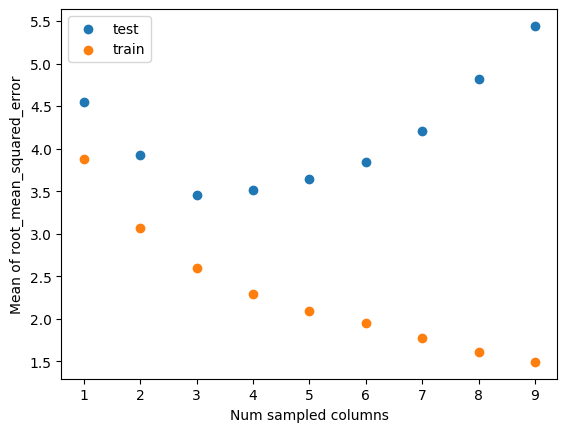

In [31]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.scatter(num_columns_list, np.mean(metric_dict['train'], axis=0), label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

## Double descent

A paper by Dar et al. (), called "Farewell to Bias Variance?" showed mathematically that double descent could be exhibited by linear regression under certain conditions. 

The paper: 
Yehuda Dar, Muthukumar, V., & Baraniuk, R. (2021). A Farewell to the Bias-Variance Tradeoff? An Overview of the Theory of Overparameterized Machine Learning. https://arxiv.org/abs/2109.02355


Here I show double descent empirically on the mtcars data set (widely used by R users).

Seeing double descent requires that the number of parameters should be a lot MORE than the number of rows. Since the data set has only 9 columns, we achieve this with a trick-- sampling fewer rows.

This section will train on 7 rows (out of a total of 32).

As before, will sample between 2 and 8 columns (out of a total of 9 columns) to see how the error metric varies by the number of parameters.  

The linear regression model will be able to fully interpolate the data at 7 columns because it is fit to 7 rows.

In [32]:
num_train_rows = 7
model = linear_model.LinearRegression(fit_intercept=True)

We will look at the train and test error of root mean squared error.

In [33]:
metric = root_mean_squared_error
metrics = [
        sample_eval.MetricTuple('train', metric_func=metric, dataset_type=sample_eval.DatasetType.train),
        sample_eval.MetricTuple('test', metric_func=metric, dataset_type=sample_eval.DatasetType.test)
    ]

In [34]:
num_samples = 300
num_columns_list = range(1, X.shape[1])
random_state = np.random.RandomState(33) # set for reproducibility
metric_dict = sample_eval.sample_and_calc_metrics_by_rows_and_cols(X, y, num_train_rows, num_columns_list=num_columns_list, model=model, metric_tuples=metrics, num_samples=num_samples, replace=False, random_state=random_state)

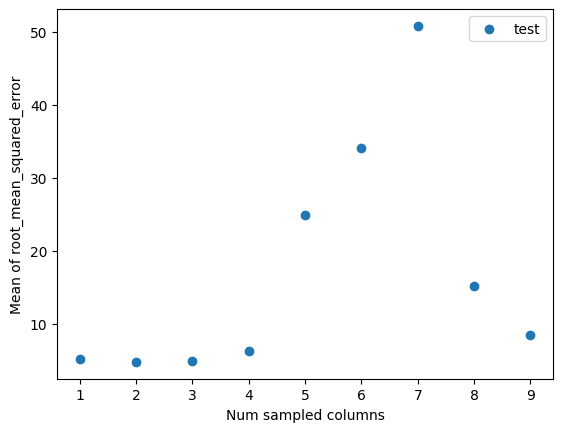

In [35]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()

As predicted, there was a spike in test (out of sample) error followed by a descent in error after the spike.  That is double descent in a linear regression.  The maximum was reached at 7 sampled columns.

Double descent was formerly thought to be a weird feature of fitting neural nets, but here we observe it with simple, traditional linear regression.

## Deeper dive into interpolation

The double descent spike should happen at the interpolation point.  Interpolation means the data could be fit perfectly, so the training error is zero.  Let's look at the mean training error for each number of sampled columns

In [36]:
print(pd.DataFrame({'columns':num_columns_list, 'mean train error':np.mean(metric_dict['train'], axis=0), 'mean test error':np.mean(metric_dict['test'], axis=0)}).to_string(index=False))

 columns  mean train error  mean test error
       1      3.498993e+00         5.211286
       2      2.498344e+00         4.816154
       3      1.860063e+00         4.905365
       4      1.361846e+00         6.289021
       5      8.270998e-01        24.912459
       6      1.546239e-01        34.136874
       7      3.457017e-02        50.816633
       8      5.923881e-03        15.224733
       9      9.871127e-14         8.484712


I predicted that interpolation would happen at 7 sampled columns because we selected 7 rows, but we see the mean training error is not 0 at 7 columns nor even at 8 columns!

Considering why, focus on the mtcars data set (documentation: https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars).  It has some very low-variance, uninformative columns.  The column `vs` (engine type v or s) and the column `am` (automatic transmission or not) are both binary.  So if these columns were selected, perfect interpolation would not be achievable even with 7 columns for 7 rows. 

For completeness, below is a plot that includes both training and test error.

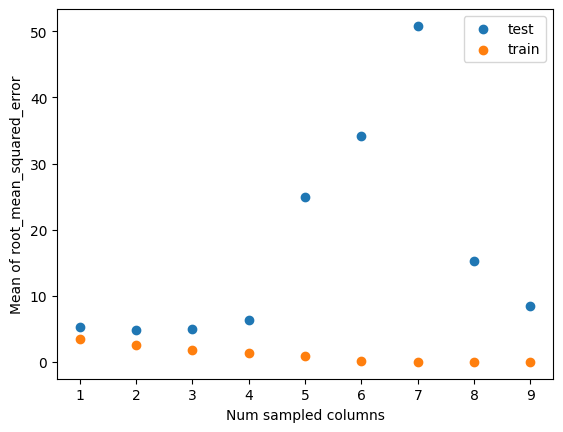

In [37]:
plt.scatter(num_columns_list, np.mean(metric_dict['test'], axis=0), label='test')
plt.scatter(num_columns_list, np.mean(metric_dict['train'], axis=0), label='train')
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.legend()
plt.show()